# 스팸 메일 분류하기

# 1. 패키지 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
from tqdm import tqdm

from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding

Using TensorFlow backend.


# 2. 데이터 불러오기

In [2]:
df = pd.read_csv('spam_train.csv', encoding = 'utf-8')

In [3]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,ham,U dun say so early hor... U c already then say...
3,ham,"Nah I don't think he goes to usf, he lives aro..."
4,ham,Even my brother is not like to speak with me. ...


In [4]:
df.shape

(4572, 2)

# 3. 데이터 전처리

#### 대문자를 소문자로 변환한다.

In [5]:
df.Message =df.Message.apply(lambda x : x.lower())

#### 카테고리를 숫자로 변환(이진 분류)

In [6]:
df.Category = df.Category.map({'ham' : 0, 'spam' : 1})

#### 특수문자 제거

In [7]:
for line in tqdm(range(len(df))):
    df.Message[line] = re.sub('[.,/!()*&$#@?^]', '',df.Message[line])

  0%|                                                                                         | 0/4572 [00:00<?, ?it/s]C:\Users\ksh\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
100%|██████████████████████████████████████████████████████████████████████████████| 4572/4572 [03:28<00:00, 21.94it/s]


In [8]:
df.head()

,Category,Message
0,0,go until jurong point crazy available only in ...
1,0,ok lar joking wif u oni
2,0,u dun say so early hor u c already then say
3,0,nah i don't think he goes to usf he lives arou...
4,0,even my brother is not like to speak with me t...


# 4. 모델링 준비

#### Train / Test 세트 분리

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.Message, df.Category, test_size = 0.2)

In [10]:
tokenizer = Tokenizer(num_words = 1000)

In [11]:
tokenizer.fit_on_texts(X_train)

In [12]:
sequences = tokenizer.texts_to_sequences(X_train)

메일의 최대 길이 : 146
메일의 평균 길이 : 12.298605


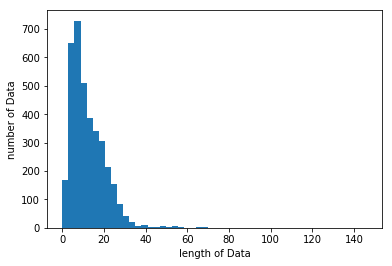

In [13]:
data = sequences
labels = df.Category
print('메일의 최대 길이 : %d' % max(len(l) for l in data))
print('메일의 평균 길이 : %f' % (sum(map(len, data))/len(data)))
plt.hist([len(s) for s in data], bins=50)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()

In [14]:
seq_matrix = pad_sequences(sequences, maxlen = 141)

In [16]:
max_words = 1000
max_len = 141

# 5. 모델링

In [21]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [22]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 141)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 141, 50)           50000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_3 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257       
__________

In [23]:
history = model.fit(seq_matrix, y_train, batch_size = 64, epochs = 10,
                   validation_split= .2, callbacks= [EarlyStopping(monitor='val_acc',mode = 'max',patience = 3)],
                   verbose = 2)

Train on 2925 samples, validate on 732 samples
Epoch 1/10
 - 6s - loss: 0.3830 - acc: 0.8711 - val_loss: 0.1901 - val_acc: 0.9672
Epoch 2/10
 - 5s - loss: 0.0851 - acc: 0.9798 - val_loss: 0.0778 - val_acc: 0.9740
Epoch 3/10
 - 6s - loss: 0.0371 - acc: 0.9887 - val_loss: 0.0783 - val_acc: 0.9781
Epoch 4/10
 - 6s - loss: 0.0188 - acc: 0.9945 - val_loss: 0.0902 - val_acc: 0.9768
Epoch 5/10
 - 7s - loss: 0.0104 - acc: 0.9983 - val_loss: 0.1036 - val_acc: 0.9781
Epoch 6/10
 - 6s - loss: 0.0075 - acc: 0.9983 - val_loss: 0.1198 - val_acc: 0.9795
Epoch 7/10
 - 6s - loss: 0.0059 - acc: 0.9990 - val_loss: 0.1106 - val_acc: 0.9795
Epoch 8/10
 - 7s - loss: 0.0070 - acc: 0.9990 - val_loss: 0.0998 - val_acc: 0.9795
Epoch 9/10
 - 5s - loss: 0.0057 - acc: 0.9993 - val_loss: 0.1056 - val_acc: 0.9809
Epoch 10/10
 - 5s - loss: 0.0039 - acc: 0.9993 - val_loss: 0.1198 - val_acc: 0.9795


In [26]:
test_sequences = tokenizer.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len)

In [28]:
accr = model.evaluate(test_sequences_matrix,y_test)

915/915 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 477us/step


In [30]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.108
  Accuracy: 0.983


# 6. 테스트 세트 평가

In [44]:
test = pd.read_csv('spam_test.csv')

In [32]:
test.head()

,Message
0,You should get more chicken broth if you want ...
1,Jokin only lar... :-) depends on which phone m...
2,"What part of ""don't initiate"" don't you unders..."
3,"Mon okie lor... Haha, best is cheap n gd food ..."
4,Aight should I just plan to come up later toni...


In [49]:
for line in tqdm(range(len(test))):
    test.Message[line] = re.sub(r'[.,/!?"":-_()@#%$^&]', '',test.Message[line])

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 9271.84it/s]


In [42]:
test.Message = test.Message.apply(lambda x : x.lower())

In [52]:
test_seq = tokenizer.texts_to_sequences(test.Message)

In [53]:
test_seq_mat = pad_sequences(test_seq, maxlen = max_len)

In [56]:
pred = []

In [55]:
pred_labels = model.predict(test_seq_mat)

In [57]:
for i in range(0, len(test)):
    pred.append(pred_labels[i][0])

In [59]:
def thresh(x):
    if x > 0.6 :
        return 1
    else:
        return 0

In [70]:
result = pd.DataFrame({'Category' : pred})#.Category.map(thresh)

In [71]:
result.Category = result.Category.map(thresh)

In [72]:
result.head()

,Category
0,0
1,0
2,0
3,0
4,0


In [73]:
result.Category.value_counts()

0    894
1    106
Name: Category, dtype: int64

# 7. submission 확인

In [ ]:
submission = pd.read_csv("spam_submission.csv")

In [79]:
submission.head()

,Category
0,0
1,0
2,0
3,0
4,0


In [76]:
from sklearn.metrics import *

In [77]:
accuracy_score(submission.Category, result.Category)

0.967

In [78]:
roc_auc_score(submission.Category, result.Category)

0.892

In [80]:
precision_score(submission.Category, result.Category)

0.9339622641509434